In [5]:
import os
import sys
import json
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Set root path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

from src.utils.spatial_processing import predictions_to_grid, define_hotspot_by_crimes
from src.utils.data_partition import temporal_split
from src.utils.visualization import compare_prediction_maps, compare_hotspot_masks, plot_hotspot_masks_over_days


# Load config
with open(os.path.join("..", "config.json"), "r") as f:
    config = json.load(f)

# Parameters from config
rows = config["data_generation"]["rows"]
cols = config["data_generation"]["cols"]
grid_size = (rows, cols)
hotspot_percentage = config["evaluation"]["hotspot_percentage"]

In [6]:
# Load data
df = pd.read_csv("../data/examples/poisson_example_40x40.csv")

# Partition data
train_days = config["data_partition"]["train_months"] * 30
calib_days = config["data_partition"]["calibration_months"] * 30
test_days = config["data_partition"]["test_months"] * 30

df_train, df_calib, df_test = temporal_split(df, train_days, train_days + calib_days, train_days + calib_days + test_days)

# Define features
features = ["timestep", "row", "col"]
target = "count"

X_test, y_test = df_test[features], df_test[target]

# Load pre-trained models
naive_model = joblib.load("../results/models/naive_cell_model.pkl")
poisson_model = joblib.load("../results/models/poisson_cell_model.pkl")

# Predict
naive_pred = naive_model.predict(X_test)
poisson_pred = poisson_model.predict(X_test)

# Convert to spatial grids
grid_true, grid_naive = predictions_to_grid(X_test, y_test, naive_pred, grid_size)
_, grid_poisson = predictions_to_grid(X_test, y_test, poisson_pred, grid_size)

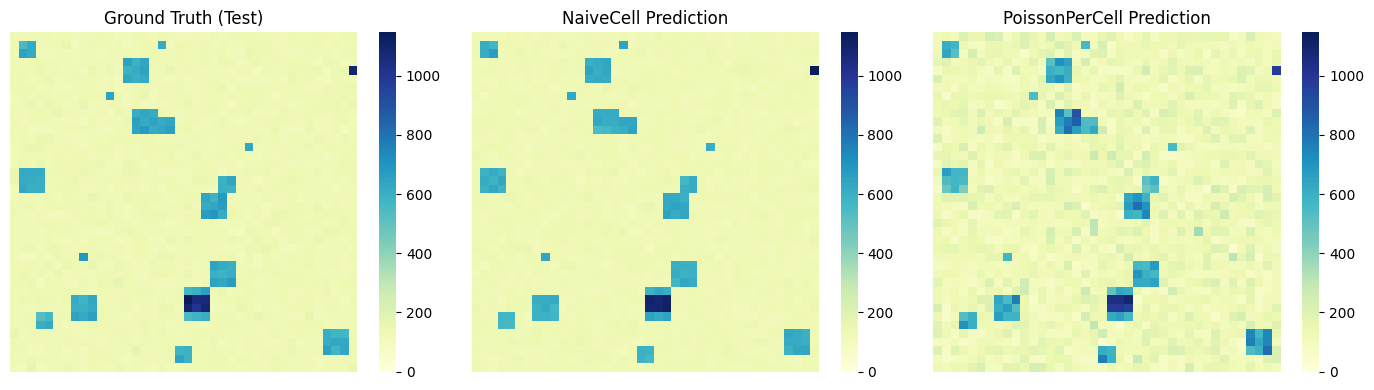

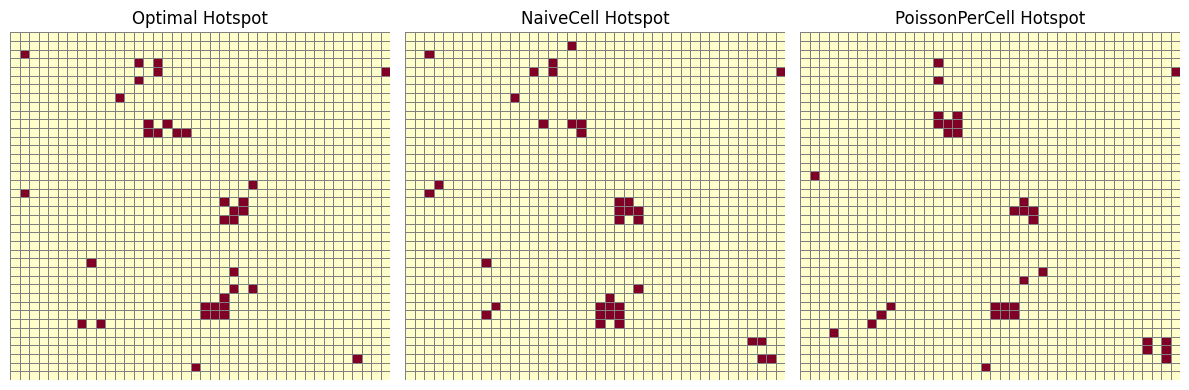

In [7]:
# Define hotspot masks
hotspot_naive = define_hotspot_by_crimes(grid_naive, hotspot_percentage)
hotspot_poisson = define_hotspot_by_crimes(grid_poisson, hotspot_percentage)
hotspot_optimal = define_hotspot_by_crimes(grid_true, hotspot_percentage)

# 🔍 Visualize aggregated prediction maps
compare_prediction_maps(
    [grid_true, grid_naive, grid_poisson],
    ["Ground Truth (Test)", "NaiveCell Prediction", "PoissonPerCell Prediction"],
    vmin=0, vmax=np.max(grid_true),
    figsize=(14, 4)
)

# 🔍 Visualize aggregated hotspot masks
compare_hotspot_masks(
    [hotspot_optimal, hotspot_naive, hotspot_poisson],
    ["Optimal Hotspot", "NaiveCell Hotspot", "PoissonPerCell Hotspot"],
    ncols=3, figsize=(12, 4)
)

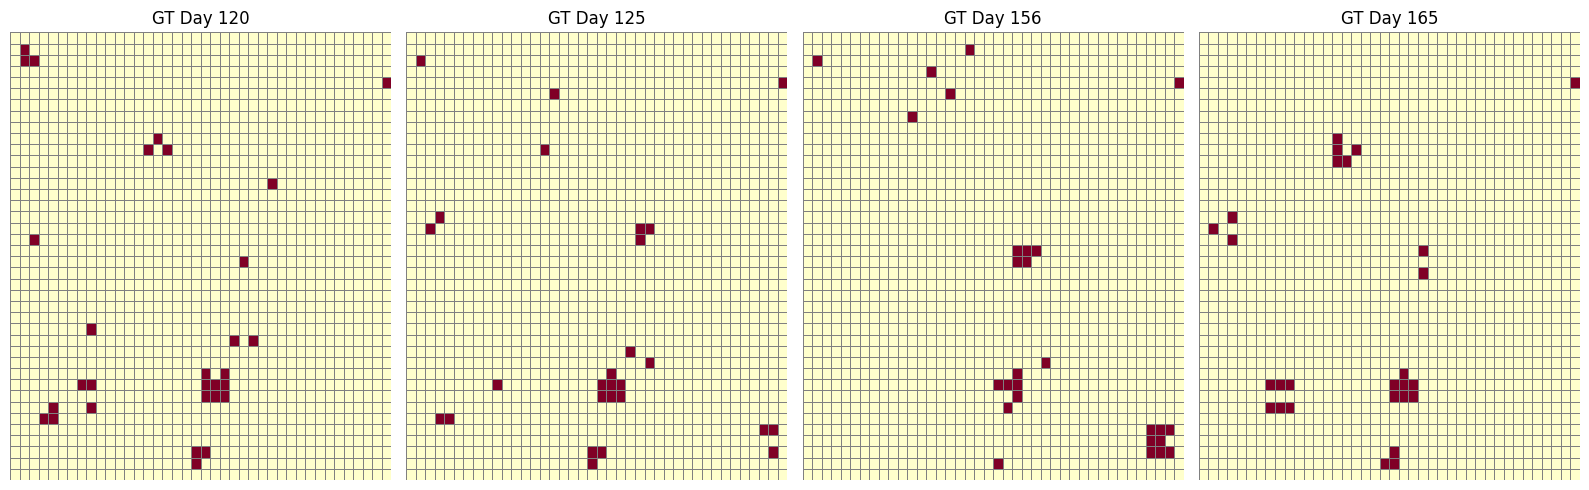

In [13]:

np.random.seed(42)
dias_aleatorios = np.random.choice(X_test["timestep"].unique(), size=4, replace=False)


masks_gt = []

for t in dias_aleatorios:
    idx = X_test["timestep"] == t
    X_day = X_test[idx]
    y_day = y_test[idx]

    grid_gt = np.zeros(grid_size)
    for r, c, v in zip(X_day["row"], X_day["col"], y_day):
        grid_gt[r, c] = v

    mask = define_hotspot_by_crimes(grid_gt, hotspot_percentage)
    masks_gt.append(mask)


mask_dict = {f"GT Day {t}": m for t, m in zip(dias_aleatorios, masks_gt)}


plot_hotspot_masks_over_days(mask_dict, ncols=4, figsize=(16, 5))
